**Data:** 
- 10 years’ of weather data (2007-2017) from 49 weather centers from  7 climate zones <br>
  source: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
  
  
- climate zone data <br>
  source: https://www.abcb.gov.au/Resources/Tools-Calculators/Climate-Zone-Map-Australia-Wide


**Target:** 
- Prediction 1: Will there be rain tomorrow? (Binary Classification/Binary Clustering) <br>
- Prediction 2: What  is the probable amount of rain in mm? (Regression)

***
**Missing data imputation** 

Little’s test in R (I could not find anything in Python!) – identification of (MCAR/MCR/MCNR). <br>This is just a formal step before choosing any imputation method.

_The possible choices for imputations_
> 1. Delete the rows with NaN
> 2. Median imputation for numerical data & mode imputation for categorical data
> 3. Random imputation for numerical data & random imputation for categorical data
> 4. Fast KNN data imputation for numerical data & mode imputation for categorical data ( $ pip install impyute)

***
**Identification and imputation of  Outliers**

_The possible choices for detection of outliers_
>1.	Z score (Z>3). If we use this we also need to perform Shapiro Wilk Test to validate the normality of the dataframe columns
>2.	IQR score (3xIQR). 

_The possible choices for imputations_
> min max capping

I am not very sure whether we can increase the accuracy of prediction by imputing the outliers. So far what I have done (with and without outliers), I did not observe any significant change - DB

***
**Dealing with the Data Imbalance**

_The possible choices_
> 1. random over sampling 
> 2. Synthetic Minority Over-Sampling Technique (SMOTE)
> 3. Adaptive Synthetic (ADASYN)

***
**Feature Selection and Dimensionality Reduction**

_The possible choices_

> 1. Correlation heat map
> 2. Extra Tree Classifier
> 3. SelectKBest and Chi2 test
> 4. PCA for numerical data (feature scaling important)

Feature scaling(?)

***
**Training/Test Data Splitting**

_The possible choices_
> 1. Random splitting  (WY)
> 2. Temporal splitting (DB)

***
**Binary Classification**

_The possible choices_

> 1. Logistic Regreesion
> 2. QDA
> 3. LDA
> 4. Random Forest
> 5. AdaBoost
> 6. SVM 
         1. linear
         2. nonlinear
> 6. NN - MLP
  

In [41]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import plot_roc_curve
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# !pip install imblearn
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
# from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


## Elementary Data Processing

In [25]:
#load data and show sample data
data = 'weatherAUS.csv'
df = pd.read_csv(data)
# print(df.shape)
# df.head()

#Data copy V1 only 
df1 = df.copy()
#drop useless column RISk_MM(not necessary in the binary classfying task)
df1.drop(columns = ['RISK_MM'],axis=1,inplace=True)
# df1.info()

In [26]:
#convert data(string form) to numerical values in years, months, days
df1['Date'] = pd.to_datetime(df1['Date'])
df1['Year'] = df1['Date'].dt.year
df1['Month'] = df1['Date'].dt.month
df1['Day'] = df1['Date'].dt.day
# drop the original Date variable and put Year, Month and Day columns at the beginning   
df1.drop('Date', axis=1, inplace = True)
cols = list(df1)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Day')))
cols.insert(0, cols.pop(cols.index('Month')))
cols.insert(0, cols.pop(cols.index('Year')))
df1 = df1.loc[:, cols]
df1.head()

,Year,Month,Day,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008,12,1,Albury,13.4,22.9,0.6,NaN,NaN,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008,12,2,Albury,7.4,25.1,0.0,NaN,NaN,WNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008,12,3,Albury,12.9,25.7,0.0,NaN,NaN,WSW,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008,12,4,Albury,9.2,28.0,0.0,NaN,NaN,NE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008,12,5,Albury,17.5,32.3,1.0,NaN,NaN,W,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [27]:
# adding the climate zone information based on the weather center
data2 = 'Location_Zone.csv'
df2 = pd.read_csv(data2)
# df2.head()

df1['Zone'] = np.nan
for i in range(len(df2.values[:,0])):
    f = df2.values[i,0]
    df1.loc[df1['Location'] == f,'Zone'] = df2.values[df2['Location'] == f,1]
cols = list(df1)
# move the column to head of list using index, pop and insert
cols.insert(4, cols.pop(cols.index('Zone')))
df1 = df1.loc[:, cols]
# df1.head()

In [28]:
# detect the number of unique climate zones in the data
climate_zones = np.sort(df1['Zone'].unique())
# print('The unique climate zones are:')
# print(climate_zones)

In [29]:
# new dataframes based on zone value
df1_tmp = df1.copy()
for i in range (len(climate_zones)):
    i += 1
    function_string1 = "df_zone"+str(i)+" = df1_tmp[df1_tmp['Zone'] == "+str(i)+"]"
    function_string2 = "df_zone"+str(i)+".drop('Zone', axis=1, inplace = True)"
    function_string3 = "print(df_zone"+str(i)+".shape)"
    exec(function_string1)
    exec(function_string2)
    print("Zone"+str(i)+" shape: "),
    exec(function_string3)


/Users/debojyotibiswas/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Zone1 shape: 
(10772, 25)
Zone2 shape: 
(9094, 25)
Zone3 shape: 
(3031, 25)
Zone4 shape: 
(26821, 25)
Zone5 shape: 
(44613, 25)
Zone6 shape: 
(32236, 25)
Zone7 shape: 
(15626, 25)


In [30]:
df_zone1.head()

,Year,Month,Day,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
84855,2008,12,1,Cairns,25.2,32.3,0.4,4.0,6.4,NE,...,62.0,66.0,1011.3,1008.1,5.0,7.0,31.2,30.7,No,Yes
84856,2008,12,2,Cairns,24.2,32.3,8.4,6.6,5.3,NE,...,75.0,62.0,1011.9,1008.0,7.0,7.0,29.0,31.1,Yes,No
84857,2008,12,3,Cairns,23.9,32.8,0.6,5.6,11.3,SSE,...,69.0,42.0,1012.2,1009.9,7.0,5.0,29.1,31.6,No,No
84858,2008,12,4,Cairns,22.2,33.6,0.0,9.6,12.3,SE,...,60.0,31.0,1013.3,1010.9,2.0,1.0,29.6,32.5,No,No
84859,2008,12,5,Cairns,23.2,33.5,0.0,11.6,11.8,SE,...,64.0,56.0,1013.8,1011.0,4.0,2.0,29.7,32.2,No,No


# Data analysis
- The following procedures will be defined as function
- Each dataframe (e.g., df_zone1, df_zone2) can run the procedures.
- Now use df_zone1 as the example.

In [31]:
# view summary statistics in numerical variables to detect any anomaly in the data -- outliers etc.
def stat_summary(df):
    data = df
    numerical = [var for var in data.columns if df[var].dtype!='O']
    print(round(data[numerical[3:]].describe()),2)
    
# stat_summary(df_zone1)

In [32]:
# Boxplots are used to detect the outliers present in the data
def boxplot_each_zone(df):
    plt.figure(figsize=(18,20))
    plt.subplot(4, 4, 1)
    fig = df.boxplot(column='Rainfall')
    fig.set_ylabel('Rainfall')

    plt.subplot(4, 4, 2)
    fig = df.boxplot(column='Evaporation')
    fig.set_ylabel('Evaporation')

    plt.subplot(4, 4, 3)
    fig = df.boxplot(column='WindSpeed9am')
    fig.set_ylabel('WindSpeed9am')

    plt.subplot(4, 4, 4)
    fig = df.boxplot(column='WindSpeed3pm')
    fig.set_ylabel('WindSpeed3pm')

    #--------------------------------------------------
    plt.subplot(4, 4, 5)
    fig = df.boxplot(column='Cloud3pm')
    fig.set_ylabel('Cloud3pm')

    plt.subplot(4, 4, 6)
    fig = df.boxplot(column='Cloud9am')
    fig.set_title('')
    fig.set_ylabel('Cloud9am')

    plt.subplot(4, 4, 7)
    fig = df.boxplot(column='Humidity3pm')
    fig.set_ylabel('Humidity3pm')

    plt.subplot(4, 4, 8)
    fig = df.boxplot(column='Humidity9am')
    fig.set_ylabel('Humidity9am')

    #--------------------------------------------------
    plt.subplot(4, 4, 9)
    fig = df.boxplot(column='MaxTemp')
    fig.set_ylabel('MaxTemp')

    plt.subplot(4, 4, 10)
    fig = df.boxplot(column='MinTemp')
    fig.set_ylabel('MinTemp')

    plt.subplot(4, 4, 11)
    fig = df.boxplot(column='Pressure3pm')
    fig.set_ylabel('Pressure3pm')

    plt.subplot(4, 4, 12)
    fig = df.boxplot(column='Pressure9am')
    fig.set_ylabel('Pressure9am')

    #--------------------------------------------------
    plt.subplot(4, 4, 13)
    fig = df.boxplot(column='Sunshine')
    fig.set_ylabel('Sunshine')

    plt.subplot(4, 4, 14)
    fig = df.boxplot(column='Temp3pm')
    fig.set_ylabel('Temp3pm')

    plt.subplot(4, 4, 15)
    fig = df.boxplot(column='Temp9am')
    fig.set_ylabel('Temp9am')

    plt.subplot(4, 4, 16)
    fig = df.boxplot(column='WindGustSpeed')
    fig.set_ylabel('WindGustSpeed')

    plt.show()

# boxplot_each_zone(df_zone1)

In [33]:
# find categorical and numerical variables 
def cat_num_identify(df):
    categorical = [var for var in df.columns if df[var].dtype=='O']
    numerical = [var for var in df.columns if df[var].dtype!='O']
    return categorical, numerical

df_zone1_categorical_col, df_zone1_numerical_col = cat_num_identify(df_zone1)

In [34]:
# Plot correlation matrix to find out most correlated numerical variables
def correlation_plot(df):
    df_tmp2 = df.copy()
    df_tmp2 = df_tmp2.drop(['Year', 'Month', 'Day'], axis=1)
    correlation = df_tmp2.corr()

    plt.figure(figsize=(16,12))
    plt.title('Correlation Heatmap')
    ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
    plt.show()

# correlation_plot(df_zone1)

In [35]:
# Pairwise correlation plots
def correlation_plot_type2(df):
    num_var = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm']
    sns.pairplot(df[num_var][~np.isnan(df[num_var])], kind='scatter', diag_kind='hist', palette='Rainbow') 
    # sns.pairplot(df_zone1[num_var], kind='scatter', diag_kind='kde', palette='Rainbow')
    plt.show()

# correlation_plot_type2(df_zone1)    

## Missing Data Imputation

In [36]:
def imputation_df(df, categorical_col, numerical_col,method):
    df_imputed = df.copy()
    
    if method == 'mean': 
        #impute numerical columns
        imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
        df_imputed[numerical_col] = imp_num.fit_transform(df[numerical_col])

    
    elif method == 'median': 
        #impute numerical columns
        imp_num = SimpleImputer(missing_values=np.nan, strategy='median')
        df_imputed[numerical_col] = imp_num.fit_transform(df[numerical_col])
    
        
        
    elif method == 'fastknn':         
        from impyute import fast_knn
        from scipy.spatial import KDTree
        
        #impute numerical columns
        df_imputed[numerical_col] = fast_knn(df[numerical_col], k=3)

    #do scaling for numerical columns
    scaler = MinMaxScaler()
    df_imputed[numerical_col] = scaler.fit_transform(df_imputed[numerical_col])    
    
    #impute categorical columns
    imp_cat = SimpleImputer(strategy="most_frequent")
    df_imputed[categorical_col] = imp_cat.fit_transform(df[categorical_col])
    
    return df_imputed

# df = df_zone1;
# categorical_col, numerical_col = cat_num_identify(df)
# df_imputed = imputation_df(df, categorical_col,numerical_col,'mean')  
# # Cross check if the data imputation is sucessful
# print('--------------------------------------------------------------------------')
# print('missing values in the numerical variables')
# print('--------------------------------------------------------------------------')
# print(df_imputed[numerical_col].isnull().sum())
# print('--------------------------------------------------------------------------')
# print('missing values in the categorical variables')
# print('--------------------------------------------------------------------------')
# print(df_imputed[categorical_col].isnull().sum())

## Outliers Imputation

In [37]:
# Maximum and Minimum Capping Values
def max_min_cap(df):
    df_tmp = df.copy()
    df_tmp = df_tmp.drop(['Year','Month','Day'], axis = 1);
    IQR = df_tmp.quantile(0.75) - df_tmp.quantile(0.25);

    max_allowable_values = df_tmp.quantile(0.5) + 3*IQR;
    min_allowable_values = df_tmp.quantile(0.5) - 3*IQR;
    
    return  max_allowable_values,min_allowable_values
#     print('--------------------------------------------------------------------------')
#     print('Maximum Allowable Values = median + 3 x IQR')
#     print('--------------------------------------------------------------------------')
#     print(max_allowable_values)
#     print('--------------------------------------------------------------------------')
#     print('Minimum Allowable Values = median - 3 x IQR')
#     print('--------------------------------------------------------------------------')
#     print(min_allowable_values)
    
# max_min_cap(df_zone1)

# Improve Outliers
# Capping the variable values by replacing outliers with values = median+3*IQR or median-3*IQR 

def improve_outlier(df):
    df_1 = df.drop(['Year','Month','Day'], axis = 1);

    df_1_low = (df_1 < min_allowable_values);
    df_1_high = (df_1 > max_allowable_values);
    df_1.where(df_1_low, min_allowable_values, axis=1);
    df_1.where(df_1_high, max_allowable_values, axis=1);
    
    return df_1

## Oversampling to deal with the imbalanced data

In [42]:
## Ratio for No/Yes in RainTomorrow
No_Rain  = [df.RainTomorrow == 'No']
Yes_Rain = [df.RainTomorrow == 'Yes']
No_Rain  = [df_zone1.RainTomorrow == 'No']
Yes_Rain = [df_zone1.RainTomorrow == 'Yes']
print('Number of NO  in original  df:', np.sum(No_Rain))
print('Number of Yes in original  df:',np.sum(Yes_Rain))
## Ratio 
print('Raio of No/Yes in original  df:', np.sum(No_Rain)/np.sum(Yes_Rain))


# ## Test random oversampling
# ros = RandomOverSampler(random_state=0)
# No_Rain_OS_resampled, Yes_Rain_OS_resampled = ros.fit_resample(df, df.RainTomorrow)
# # print(No_Rain_OS_resampled)
# No_Rain1  = [No_Rain_OS_resampled.RainTomorrow  == 'No']
# Yes_Rain1 = [No_Rain_OS_resampled.RainTomorrow  == 'Yes']
# print('Number of NO:' ,np.sum(No_Rain1))
# print('Number of Yes:',np.sum(Yes_Rain1))
# ## Ratio 
# print('Raio of No/Yes', np.sum(No_Rain1)/np.sum(Yes_Rain1))



## Oversampling the outliers based on RainTomorrow

def Over_Sampling(df, method):
    df_OS = df.copy() 

    # RandomOverSampler Method
    if method == 'RandomOverSampler': 
        ros = RandomOverSampler(random_state=0)
        df_resamped, RainTomorrow_resampled = ros.fit_resample(df_OS, df.RainTomorrow)
    
    # Synthetic Minority Over-Sampling Technique - SMOTE
    elif method == 'SMOTE': 
        df_resampled, RainTomorrow_resampled = SMOTE().fit_resample(df_OS, df.RainTomorrow)
      
    # Adaptive Synthetic (ADASYN)    
    elif method == 'ADASYN': 
        df_resampled, RainTomorrow_resampled =ADASYN().fit_resample(df_OS, df.RainTomorrow)
    
    return df_resamped

# df_zone1.head()
# categorical_col, numerical_col = cat_num_identify(df_zone1)
# df_zone1_float[categorical_col] = df[categorical_col].astype(float)


# df_zone1_os = Over_Sampling(df_zone1, 'SMOTE') 





## Test to see if it oversampling works
No_Rain2  = [df_zone1_os.RainTomorrow  == 'No']
Yes_Rain2 = [df_zone1_os.RainTomorrow  == 'Yes']
print('Number of NO  in oversampled df:' , np.sum(No_Rain2))
print('Number of Yes in oversampled df:', np.sum(Yes_Rain2)) 
## Ratio 
print('Raio of No/Yes in oversampled df', np.sum(No_Rain2)/np.sum(Yes_Rain2))

# # df


Number of NO  in original  df: 8186
Number of Yes in original  df: 2586
Raio of No/Yes in original  df: 3.165506573859242


NameError: name 'df_zone1_os' is not defined

## Change categorical data to dummy vars

In [ ]:
#Convert categorical variable into dummy/indicator variables.
def cat_dummy(df, numerical_col):
    #we need to make sure drop_first=True, otherwise there be one redundant dummy variable
    #we also need to add prefix attributes, otherwise many columns will have same name
    df_final = pd.concat([df[numerical_col], 
                         pd.get_dummies(df.Location, prefix='Location',drop_first=True), 
                         pd.get_dummies(df.WindGustDir, prefix='WindGustDir', drop_first=True),
                         pd.get_dummies(df.WindDir9am, prefix='WindDir9am', drop_first=True),
                         pd.get_dummies(df.WindDir3pm, prefix='WindDir3pm',drop_first=True),
                         pd.get_dummies(df.RainToday, prefix='RainToday',drop_first=True),
                         pd.get_dummies(df.RainTomorrow, prefix='RainTomorrow', drop_first=True)], axis=1)

    return df_final

# df_zone1_final = cat_dummy(df_zone1_imputed, df_zone1_numerical_col)
# df_zone1_final.head()
# for col in df_zone1_final.columns:
#     print(col,end=", ")

## Plot the zone1 data directly

In [ ]:
#df_zone1_categorical_col, df_zone1_numerical_col = cat_num_identify(df_zone1)
df_imputed_zone1 = imputation_df(df_zone1, df_zone1_categorical_col,df_zone1_numerical_col,'mean')    
df_imputed_zone1.info()
df_final_zone1 = cat_dummy(df_imputed_zone1, df_zone1_numerical_col)
df_final_zone1.info()

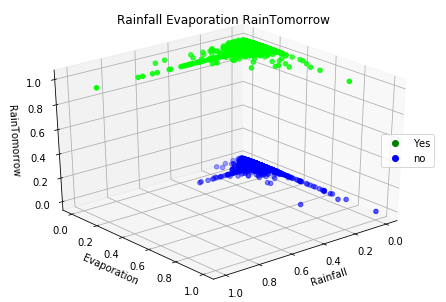

In [79]:
#3D plot based on Rainfall and Evaporation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
fig = plt.figure(figsize=(6,4))

ax = Axes3D(fig, elev=30, azim=50)
ax.scatter(df_final_zone1['Rainfall'], df_final_zone1['Evaporation'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("Rainfall");
ax.set_ylabel("Evaporation");
ax.set_zlabel("RainTomorrow");
ax.set_title('Rainfall Evaporation RainTomorrow')
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)
fig.savefig('Rainfall_Evaporation_RainTom.svg', format='svg')

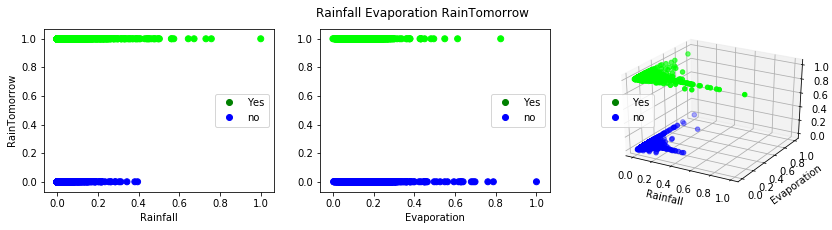

In [80]:
#3D plot with subplots based on Rainfall and Evaporation
fig = plt.figure(figsize = (14,3))
fig.suptitle('Rainfall Evaporation RainTomorrow')

# First subplot
ax = fig.add_subplot(1, 3, 1)
ax.scatter(df_final_zone1['Rainfall'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('Rainfall');
ax.set_ylabel('RainTomorrow');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Second subplot
ax = fig.add_subplot(1, 3, 2)
ax.scatter(df_final_zone1['Evaporation'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('Evaporation');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)
#ax.set_ylabel('RainTomorrow_Yes');

# Third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(df_final_zone1['Rainfall'], df_final_zone1['Evaporation'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("Rainfall");
ax.set_ylabel("Evaporation");
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=6)
#ax.set_zlabel("RainTomorrow_Yes");

plt.show()
fig.savefig('Rainfall_Evaporation_RainTommorrow_Subplots.svg', format='svg')


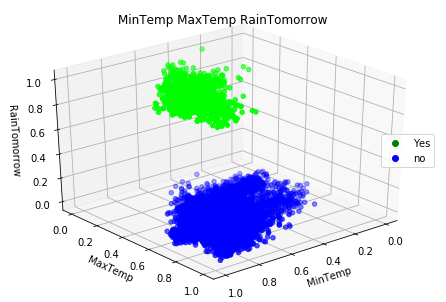

In [76]:
#3D plot based on MinTemp and MaxTemp
fig = plt.figure(figsize=(6,4))
ax = Axes3D(fig, elev=30, azim=50)
ax.scatter(df_final_zone1['MinTemp'], df_final_zone1['MaxTemp'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("MinTemp");
ax.set_ylabel("MaxTemp");
ax.set_zlabel("RainTomorrow");
ax.set_title('MinTemp MaxTemp RainTomorrow')
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)
fig.savefig('MinTemp_MaxTemp_RainTomorrow.svg', format='svg')

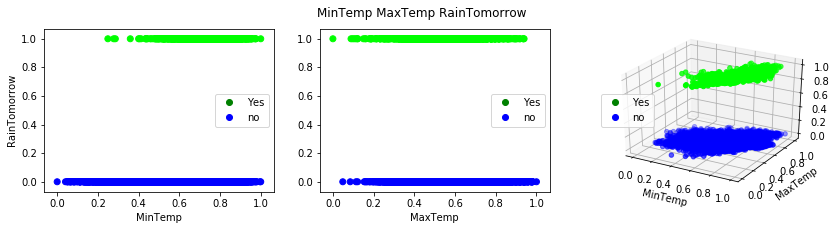

In [81]:
#3D plot with subplots based on MinTemp and MaxTemp
fig = plt.figure(figsize = (14,3))
fig.suptitle('MinTemp MaxTemp RainTomorrow')

# First subplot
ax = fig.add_subplot(1, 3, 1)
ax.scatter(df_final_zone1['MinTemp'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('MinTemp');
ax.set_ylabel('RainTomorrow');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Second subplot
ax = fig.add_subplot(1, 3, 2)
ax.scatter(df_final_zone1['MaxTemp'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('MaxTemp');
#ax.set_ylabel('RainTomorrow_Yes');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(df_final_zone1['MinTemp'], df_final_zone1['MaxTemp'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("MinTemp");
ax.set_ylabel("MaxTemp");
#ax.set_zlabel("RainTomorrow_Yes");
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=6)

plt.show()
fig.savefig('MinTemp_MaxTemp_RainTomorrow_Subplots.svg', format='svg')

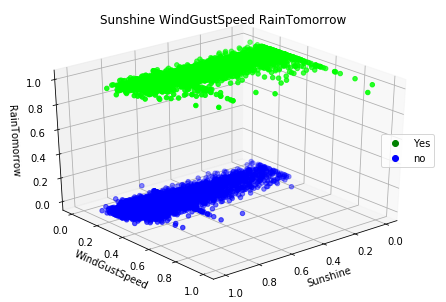

In [82]:
#3D plot based on Sunshine and WindGustSpeed
fig = plt.figure(figsize=(6,4))
ax = Axes3D(fig, elev=30, azim=50)
ax.scatter(df_final_zone1['Sunshine'], df_final_zone1['WindGustSpeed'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("Sunshine");
ax.set_ylabel("WindGustSpeed");
ax.set_zlabel("RainTomorrow");
ax.set_title('Sunshine WindGustSpeed RainTomorrow')
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)
fig.savefig('Sunshine_WindGustSpeed_RainTomorrow.svg', format='svg')

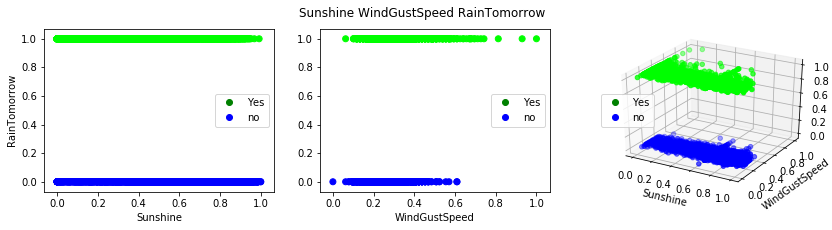

In [83]:
#3D plot with subplots based on MinTemp and MaxTemp
fig = plt.figure(figsize = (14,3))
fig.suptitle('Sunshine WindGustSpeed RainTomorrow')

# First subplot
ax = fig.add_subplot(1, 3, 1)
ax.scatter(df_final_zone1['Sunshine'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('Sunshine');
ax.set_ylabel('RainTomorrow');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Second subplot
ax = fig.add_subplot(1, 3, 2)
ax.scatter(df_final_zone1['WindGustSpeed'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('WindGustSpeed');
#ax.set_ylabel('RainTomorrow_Yes');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(df_final_zone1['Sunshine'], df_final_zone1['WindGustSpeed'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("Sunshine");
ax.set_ylabel("WindGustSpeed");
#ax.set_zlabel("RainTomorrow_Yes");
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=6)

plt.show()
fig.savefig('Sunshine_WindGustSpeed_RainTomorrow_Subplots.svg', format='svg')

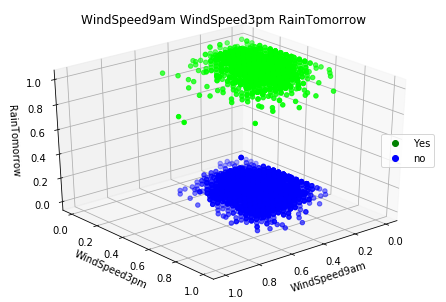

In [84]:
#3D plot based on WindSpeed9am and WindSpeed3pm
fig = plt.figure(figsize=(6,4))
ax = Axes3D(fig, elev=30, azim=50)
ax.scatter(df_final_zone1['WindSpeed9am'], df_final_zone1['WindSpeed3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("WindSpeed9am");
ax.set_ylabel("WindSpeed3pm");
ax.set_zlabel("RainTomorrow");
ax.set_title('WindSpeed9am WindSpeed3pm RainTomorrow')
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)
fig.savefig('WindSpeed9am_WindSpeed3pm_RainTomorrow.svg', format='svg')

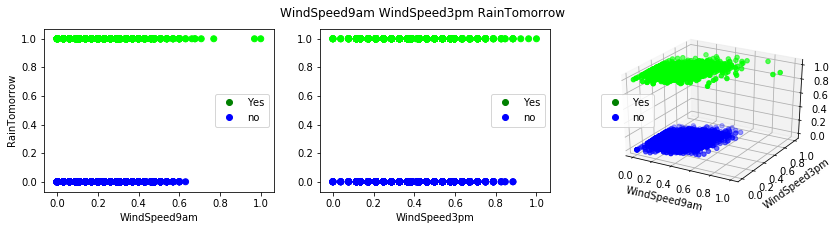

In [85]:
#3D plot with subplots based on WindSpeed9am and WindSpeed3pm
fig = plt.figure(figsize = (14,3))
fig.suptitle('WindSpeed9am WindSpeed3pm RainTomorrow')

# First subplot
ax = fig.add_subplot(1, 3, 1)
ax.scatter(df_final_zone1['WindSpeed9am'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('WindSpeed9am');
ax.set_ylabel('RainTomorrow');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Second subplot
ax = fig.add_subplot(1, 3, 2)
ax.scatter(df_final_zone1['WindSpeed3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('WindSpeed3pm');
#ax.set_ylabel('RainTomorrow_Yes');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(df_final_zone1['WindSpeed9am'], df_final_zone1['WindSpeed3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("WindSpeed9am");
ax.set_ylabel("WindSpeed3pm");
#ax.set_zlabel("RainTomorrow_Yes");
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=6)

plt.show()
fig.savefig('WindSpeed9am_WindSpeed3pm_RainTomorrow_Subplots.svg', format='svg')

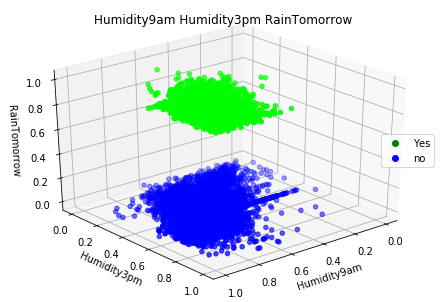

In [86]:
#3D plot based on Humidity9am and Humidity3pm
fig = plt.figure(figsize=(6,4))
ax = Axes3D(fig, elev=30, azim=50)
ax.scatter(df_final_zone1['Humidity9am'], df_final_zone1['Humidity3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("Humidity9am");
ax.set_ylabel("Humidity3pm");
ax.set_zlabel("RainTomorrow");
ax.set_title('Humidity9am Humidity3pm RainTomorrow')
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)
fig.savefig('Humidity9am_Humidity3pm_RainTomorrow.svg', format='svg')

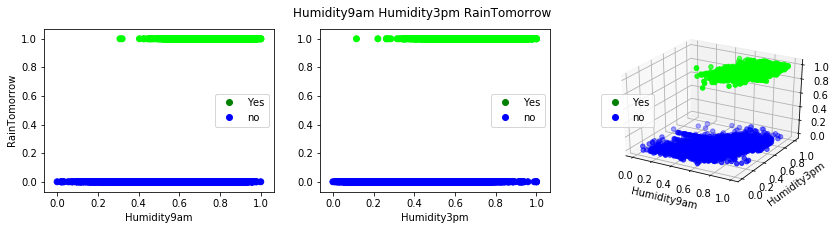

In [87]:
#3D plot with subplots based on on Humidity9am and Humidity3pm
fig = plt.figure(figsize = (14,3))
fig.suptitle('Humidity9am Humidity3pm RainTomorrow')

# First subplot
ax = fig.add_subplot(1, 3, 1)
ax.scatter(df_final_zone1['Humidity9am'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('Humidity9am');
ax.set_ylabel('RainTomorrow');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Second subplot
ax = fig.add_subplot(1, 3, 2)
ax.scatter(df_final_zone1['Humidity3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('Humidity3pm');
#ax.set_ylabel('RainTomorrow_Yes');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(df_final_zone1['Humidity9am'], df_final_zone1['Humidity3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("Humidity9am");
ax.set_ylabel("Humidity3pm");
#ax.set_zlabel("RainTomorrow_Yes");
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=6)

plt.show()
fig.savefig('Humidity9am_Humidity3pm_RainTomorrow_Subplots.svg', format='svg')

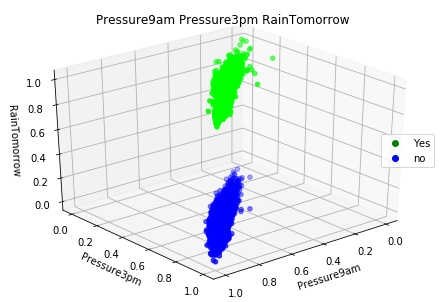

In [88]:
#3D plot based on Pressure9am and Pressure3pm
fig = plt.figure(figsize=(6,4))
ax = Axes3D(fig, elev=30, azim=50)
ax.scatter(df_final_zone1['Pressure9am'], df_final_zone1['Pressure3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("Pressure9am");
ax.set_ylabel("Pressure3pm");
ax.set_zlabel("RainTomorrow");
ax.set_title('Pressure9am Pressure3pm RainTomorrow')
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)
fig.savefig('Pressure9am_Pressure3pm_RainTomorrow.svg', format='svg')


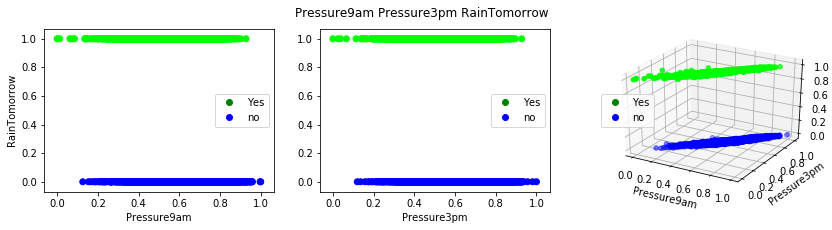

In [89]:
#3D plot with subplots based on on Pressure9am and Pressure3pm
fig = plt.figure(figsize = (14,3))
fig.suptitle('Pressure9am Pressure3pm RainTomorrow')

# First subplot
ax = fig.add_subplot(1, 3, 1)
ax.scatter(df_final_zone1['Pressure9am'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('Pressure9am');
ax.set_ylabel('RainTomorrow');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Second subplot
ax = fig.add_subplot(1, 3, 2)
ax.scatter(df_final_zone1['Pressure3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('Pressure3pm');
#ax.set_ylabel('RainTomorrow_Yes');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(df_final_zone1['Pressure9am'], df_final_zone1['Pressure3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("Pressure9am");
ax.set_ylabel("Pressure3pm");
#ax.set_zlabel("RainTomorrow_Yes");
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=6)

plt.show()
fig.savefig('Pressure9am_Pressure3pm_RainTomorrow_Subplots.svg', format='svg')

NameError: name 'df_final_zone1' is not defined

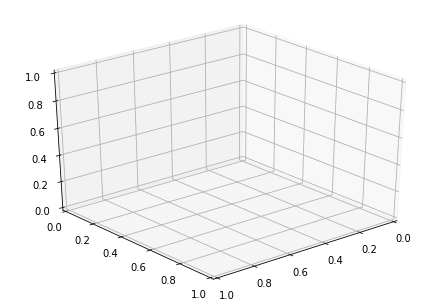

In [43]:
#3D plot based on Cloud9am and Cloud3pm
fig = plt.figure(figsize=(6,4))
ax = Axes3D(fig, elev=30, azim=50)
ax.scatter(df_final_zone1['Cloud9am'], df_final_zone1['Cloud3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("Cloud9am");
ax.set_ylabel("Cloud3pm");
ax.set_zlabel("RainTomorrow");
ax.set_title('Cloud9am Cloud3pm RainTomorrow')
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)
fig.savefig('Cloud9am_Cloud3pm_RainTomorrow.svg', format='svg')

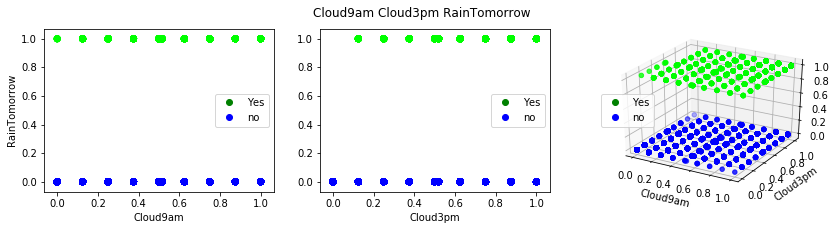

In [91]:
#3D plot with subplots based on on Cloud9am and Cloud3pm
fig = plt.figure(figsize = (14,3))
fig.suptitle('Cloud9am Cloud3pm RainTomorrow')

# First subplot
ax = fig.add_subplot(1, 3, 1)
ax.scatter(df_final_zone1['Cloud9am'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('Cloud9am');
ax.set_ylabel('RainTomorrow');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Second subplot
ax = fig.add_subplot(1, 3, 2)
ax.scatter(df_final_zone1['Cloud3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('Cloud3pm');
#ax.set_ylabel('RainTomorrow_Yes');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(df_final_zone1['Cloud9am'], df_final_zone1['Cloud3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("Cloud9am");
ax.set_ylabel("Cloud3pm");
#ax.set_zlabel("RainTomorrow_Yes");
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=6)

plt.show()
fig.savefig('Cloud9am_Cloud3pm_RainTomorrow_Subplots.svg', format='svg')

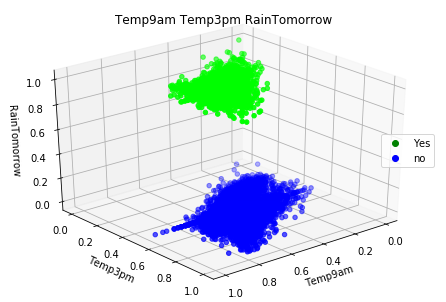

In [92]:
#3D plot based on Temp9am and Temp3pm
fig = plt.figure(figsize=(6,4))
ax = Axes3D(fig, elev=30, azim=50)
ax.scatter(df_final_zone1['Temp9am'], df_final_zone1['Temp3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("Temp9am");
ax.set_ylabel("Temp3pm");
ax.set_zlabel("RainTomorrow");
ax.set_title('Temp9am Temp3pm RainTomorrow')
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)
fig.savefig('Temp9am_Temp3pm_RainTomorrow.svg', format='svg')

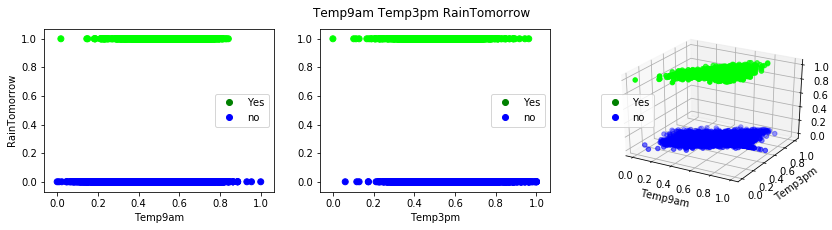

In [93]:
#3D plot with subplots based on on Temp9am and Temp3pm
fig = plt.figure(figsize = (14,3))
fig.suptitle('Temp9am Temp3pm RainTomorrow')

# First subplot
ax = fig.add_subplot(1, 3, 1)
ax.scatter(df_final_zone1['Temp9am'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('Temp9am');
ax.set_ylabel('RainTomorrow');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Second subplot
ax = fig.add_subplot(1, 3, 2)
ax.scatter(df_final_zone1['Temp3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg); 
ax.set_xlabel('Temp3pm');
#ax.set_ylabel('RainTomorrow_Yes');
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=7)

# Third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(df_final_zone1['Temp9am'], df_final_zone1['Temp3pm'], df_final_zone1['RainTomorrow_Yes'],c=df_final_zone1['RainTomorrow_Yes'], cmap=plt.cm.brg)
ax.set_xlabel("Temp9am");
ax.set_ylabel("Temp3pm");
#ax.set_zlabel("RainTomorrow_Yes");
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Yes', 'no'], numpoints = 1, loc=6)

plt.show()
fig.savefig('Temp9am_Temp3pm_RainTomorrow_Subplots.svg', format='svg')

## Training and Test Data

In [ ]:
#split data into training data (on or before YEAR) and test data (after YEAR)
def split_data_DB(df,year):
    
    df_train = df[df['Year'] <= year]
    df_test = df[df['Year'] > year]
    
    X = df.drop(['RainTomorrow_Yes'], axis=1)
    y = df['RainTomorrow_Yes']
    
    X_train = df_train.drop(['RainTomorrow_Yes'], axis=1)
    y_train = df_train['RainTomorrow_Yes']
    
    X_test = df_test.drop(['RainTomorrow_Yes'], axis=1)
    y_test = df_test['RainTomorrow_Yes']
    
    return X, y, X_train, X_test, y_train, y_test
    

In [ ]:
#split data via sklearn (usually 75% for training and 25% for testing)
def split_data_WY(df):
    X = df.drop(['RainTomorrow_Yes'], axis=1)
    y = df['RainTomorrow_Yes']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42) #42 is a magic number when using as random indicator and i don't know why
    
    return X, y, X_train, X_test, y_train, y_test
    
# X, y, X_train, X_test, y_train, y_test = split_data_WY(df)


# Prediction (classification) model
- I haven't tuned the parameters for each model
- Logistic now outperformed, but I think after tuning, other methods will perform better
- Maybe you can try to tune the parameters to improve performance

In [ ]:
methods = ["LogisticRegression", "NaiveBayes", "LDA", "QDA",  "Linear SVM", "RBF SVM", "RandomForest", "AdaBoost", "Neural Net"]
classifiers = [
    LogisticRegression(C = 10, random_state=42, solver='liblinear'),
    GaussianNB(),
    LDA(),
    QDA(),
#     KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(),
    #probability=True
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=1000)
    ]
# 

In [ ]:
def main(df,zoom_in):
    categorical_col, numerical_col = cat_num_identify(df)
    df_imputed = imputation_df(df, categorical_col,numerical_col,'median')     

    df_final = cat_dummy(df_imputed, numerical_col)
    X, y, X_train, X_test, y_train, y_test = split_data_WY(df_final)
    fig, ax = plt.subplots(figsize=(8,8))
    for method, clf in zip(methods, classifiers):
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        score_10foldCV = cross_val_score(clf, X, y, cv=10)
        if method=='Linear SVM' or method=="RBF SVM":
            plot_roc_curve(clf, X_test, y_test,ax=ax,name=str(method))
        else:
            y_pred = clf.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            ax.plot(fpr, tpr, label=str(method)+"(AUC = %0.2f" % roc_auc_score(y_test, y_pred)+')')
        print(method,"- score is : %.4f"%score, ", 10fold CV average score is: %.4f"%score_10foldCV.mean())
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    if zoom_in:  #if zoom_in = True, then enlarge the top area to get better comparision
        plt.ylim(0.7, 1)
        plt.xlim(0.4, 1)
    ax.set_title('ROC curve')
    ax.legend(loc="lower right")
    plt.show()


In [ ]:
main(df_zone1,zoom_in=False)   

In [ ]:
main(df1,zoom_in=False) # The overall data, ont stricted to zone 1

In [ ]:
# main(df_zone2)

In [ ]:
# main(df_zone3)

In [ ]:
# main(df_zone4)

In [ ]:
# main(df_zone5)

In [ ]:
# main(df_zone6)

In [ ]:
# main(df_zone7)

## Recursive feature elimination with cross-validation

In [ ]:
methods_rfe = ["LogisticRegression", "LDA", "RandomForest", "AdaBoost"]
classifiers_rfe = [
    LogisticRegression(C = 10, random_state=42, solver='liblinear'),
    LDA(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier()
    ]

# After getting the top commonly seletced features by multiple classifers
def main_rfe(df):
    categorical_col, numerical_col = cat_num_identify(df)
    df_imputed = imputation_df(df, categorical_col,numerical_col,'mean')    
    df_final = cat_dummy(df_imputed, numerical_col)
    X, y, X_train, X_test, y_train, y_test = split_data_WY(df_final)
    
    plt.figure(figsize=(8,8))
    selection = []
    for method, clf in zip(methods_rfe, classifiers_rfe):
        clf.fit(X_train, y_train)
        rfecv  = RFECV(clf, step=1, cv=5, scoring='accuracy')
        rfecv.fit(X_train, y_train)
        selection.append(rfecv.ranking_ < 11) #choose the top 10
        plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, label=str(method))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation accuracy score")
    plt.legend(loc="lower right")
    plt.show()
    
    return selection

In [ ]:
selection_zone1 = main_rfe(df_zone1)

In [ ]:
def get_common_selected_feature(selection):
    selection_overall = selection[0]
    for i in range(4):        #four methods
        selection_overall *= selection[i]
    selection_overall = np.append(selection_overall, True) #add the y column

    #show the commonly selected features
    col_final = []
    i = 0
    for col in df_zone1_final.columns:
        if selection_overall[i]==True:
            col_final.append(col)
        i += 1
    return col_final

col_final_zone1 = get_common_selected_feature(selection_zone1)

In [ ]:
col_final_zone1

In [ ]:
methods = ["LogisticRegression", "NaiveBayes", "LDA", "QDA", "KNN", "RandomForest", "AdaBoost", "Neural Net"]
classifiers = [
    LogisticRegression(C = 10, random_state=42, solver='liblinear'),
    GaussianNB(),
    LDA(),
    QDA(),
    KNeighborsClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=1000)
    ]

def main_with_selection(df, selection, zoom_in):
    categorical_col, numerical_col = cat_num_identify(df)
    df_imputed = imputation_df(df, categorical_col,numerical_col,'mean')    
    df_final = cat_dummy(df_imputed, numerical_col)
    df_final_select = df_final[selection]
    X, y, X_train, X_test, y_train, y_test = split_data_WY(df_final_select)
    
    plt.figure(figsize=(8,8))
    for method, clf in zip(methods, classifiers):
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        score_10foldCV = cross_val_score(clf, X, y, cv=10)
        y_pred = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label=str(method)+", AUC = %0.2f" % roc_auc_score(y_test, y_pred))
        print(method,"- score is : %.4f"%score, ", 10fold CV average score is: %.4f"%score_10foldCV.mean())
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if zoom_in:  #enlarge the top area to get better comparision
        plt.ylim(0.85, 1)
        plt.xlim(0.4, 1)
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
main_with_selection(df_zone1, col_final_zone1, zoom_in=False)

In [ ]:
main_with_selection(df_zone1, col_final_zone1, zoom_in=True)